In [ ]:
import pandas as pd
import numpy as np

def getExp(label_pth:str):
    
    # upload
    exp = pd.read_hdf('/root/work/data/expression/sample_matrix_fc_gtex.h5',key='fc_sample_matrix')
    ppi_orig = pd.read_csv('/root/work/data/ppi_network', index_col=0)
    label_orig = pd.read_csv(label_pth, index_col=0)
    
    # cut out patients
    exp.columns = exp.columns.map(lambda x :x.rsplit('-', 4)[0])

    # align patients
    plist1 = set(exp.columns.tolist())
    plist2 = set(label['patient'].tolist())
    plist = plist1 & plist2
    # refine
    exp_data = exp[plist].groupby(level=0, axis=1).mean()
    label = label_orig.set_index('patient')[['BRCA_Subtype_PAM50']].T[plist].T.sort_index() 

    # align genes
    glist1 = set(ppi_orig.columns.tolist())
    glist2 = set(exp.index.tolist())
    glist = glist1 & glist2
    # refine
    exp_matrix = exp.T[glist].T
    ppi = ppi_orig[glist].T[glist].sort_index().T.sort_index()

    return exp_matrix, ppi, label

In [ ]:
import os
os.chdir('/root/work/data/BRCA')
os.listdir()

In [32]:
import pandas as pd
import numpy as np
exp = pd.read_hdf('/root/work/data/expression/sample_matrix_fc_gtex.h5',key='fc_sample_matrix')
label_sub = pd.read_csv('/root/work/data/sub/brca_sub.csv', index_col=0)
label_surv = pd.read_csv('/root/work/data/survival/stad_clinical', index_col=0)

In [1]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 7))
# plt.rcParams['font.size'] = 15
# plt.hist(np.array(exp.T['PTPN9']))
# plt.xlabel('gene expression')
# plt.ylabel('count')

In [31]:
print('sub:', label_sub.shape, ' surv:', label_surv.shape)

sub: (1087, 24)  surv: (1098, 69)


In [3]:
label_surv = label_surv[['vital_status','days_to_last_follow_up','days_to_death']]
label_sub = label_sub.set_index('patient')[['BRCA_Subtype_PAM50']]
print('sub:', label_sub.shape, ' surv:', label_surv.shape)

In [18]:
label_surv = label_surv[['vital_status','days_to_last_follow_up','days_to_death']]
# label_sub = label_sub.set_index('patient')[['Molecular.Subtype']]
# print('sub:', label_sub.shape, ' surv:', label_surv.shape)

NameError: name 'label_sub' is not defined

In [19]:
def get_E(x):
    year = 365.0
    if x['vital_status'] == 'Dead':
        return x['days_to_death']
    else:
        x['vital_status'] == 'Alive'
        return x['days_to_last_follow_up']

In [33]:
label_surv = label_surv[['vital_status','days_to_last_follow_up','days_to_death']]
label_surv.loc[:,'E'] = label_surv.apply(get_E,axis=1)
label_surv['vital_status'] = label_surv['vital_status'].map({'Alive':0, 'Dead':1})
label_surv

,vital_status,days_to_last_follow_up,days_to_death,E
submitter_id,,,,
TCGA-KB-A93G,0.0,613.0,NaN,613.0
TCGA-HF-7131,0.0,NaN,NaN,NaN
TCGA-VQ-A8PM,1.0,NaN,57.0,57.0
TCGA-CD-8530,0.0,377.0,NaN,377.0
TCGA-IN-A6RJ,0.0,379.0,NaN,379.0
...,...,...,...,...
TCGA-BR-6454,0.0,0.0,NaN,0.0
TCGA-BR-A4J7,0.0,989.0,NaN,989.0
TCGA-BR-4184,1.0,0.0,212.0,212.0


In [34]:
label_surv[['days_to_death']].sort_values(by='days_to_death').dropna()

,days_to_death
submitter_id,
TCGA-CG-4462,0.0
TCGA-VQ-A923,0.0
TCGA-CG-4306,1.0
TCGA-HU-A4GQ,3.0
TCGA-BR-8363,8.0
...,...
TCGA-VQ-A924,1686.0
TCGA-RD-A8N5,1747.0
TCGA-FP-8209,1811.0


In [35]:
label_surv = label_surv[['vital_status','E']].dropna()
label_surv

,vital_status,E
submitter_id,,
TCGA-KB-A93G,0.0,613.0
TCGA-VQ-A8PM,1.0,57.0
TCGA-CD-8530,0.0,377.0
TCGA-IN-A6RJ,0.0,379.0
TCGA-KB-A6F5,0.0,169.0
...,...,...
TCGA-BR-6454,0.0,0.0
TCGA-BR-A4J7,0.0,989.0
TCGA-BR-4184,1.0,212.0


In [36]:
from lifelines.datasets import load_waltons
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Time(days)', ylabel='Survival Probability'>

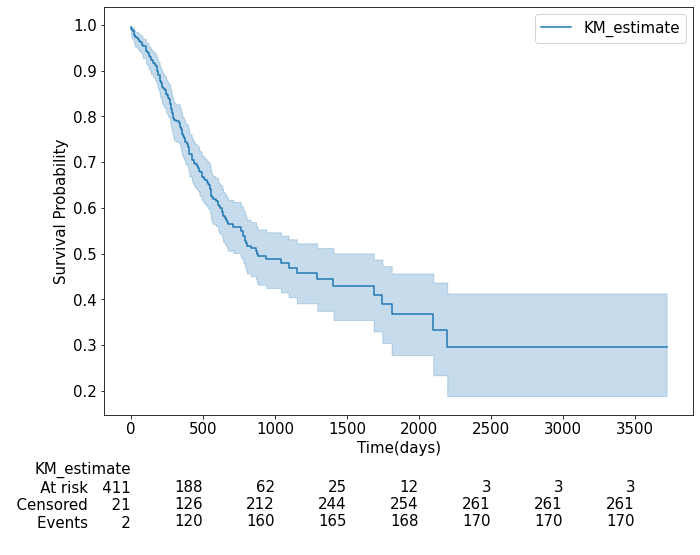

In [37]:
kmf = KaplanMeierFitter()
kmf.fit(label_surv['E'], event_observed=label_surv['vital_status'])
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 15
kmf.survival_function_  # km 生存概率
kmf.plot_survival_function(at_risk_counts=True, xlabel='Time(days)', ylabel='Survival Probability')

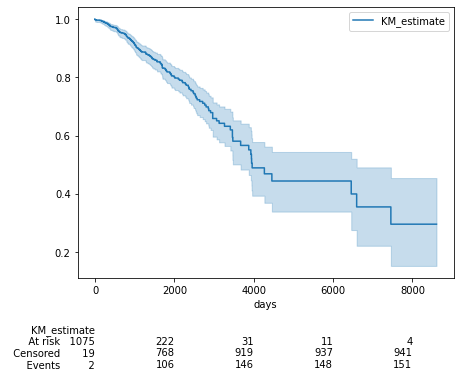

In [86]:
plt.figure(figsize=(6.5, 5.5))
kmf.plot(at_risk_counts=True, xlabel='days')
plt.tight_layout()

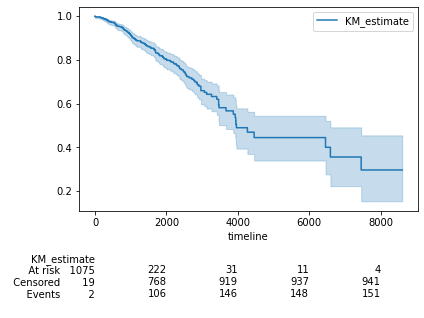

In [49]:
plt.figure(figsize=(6, 4.5))
kmf.plot_survival_function(at_risk_counts=True) # plot_survival_function + 把所有数字也显示出来
plt.tight_layout()

<AxesSubplot:xlabel='timeline'>

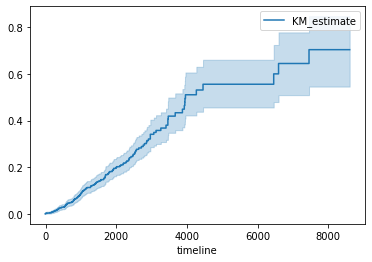

In [47]:
kmf.cumulative_density_   # 累计概率密度图
kmf.plot_cumulative_density() # # 绘制累积密度函数的漂亮图

In [9]:
def get_survival_label(x):
    year = 365.0
    if x['vital_status'] == 'Dead':
        if x['days_to_death'] < year:
            return 'STS'
        else:
            return 'LTS'
    elif x['vital_status'] == 'Alive':
        if x['days_to_last_follow_up'] > year:
            return 'LTS'
        else:
            return 'Delete!'
    else:
        return 'Delete!'

In [33]:
label_surv.loc[:,'survival_label'] = label_surv.apply(get_survival_label,axis=1)
label_surv = label_surv.drop(label_surv[label_surv.survival_label == 'Delete!'].index)
print(label_surv.shape)

(932, 4)


In [2]:
exp.columns = exp.columns.map(lambda x :x.rsplit('-', 4)[0])

In [35]:
#sub
plist1 = set(exp.columns.tolist())
plist3 = set(label_sub.index.tolist())
plist = plist1 & plist3
len(plist)

exp_sub = exp[plist].groupby(level=0, axis=1).mean()
label_sub_d = label_sub.T[plist].T.sort_index()
print('sub:', label_sub_d.shape[0])

sub: 958


In [36]:
exp_sub.to_csv('/root/work/data/sub/brca_exp_sub')
label_sub_d.to_csv('/root/work/data/sub/brca_label_sub')

In [5]:
#surv
plist1 = set(exp.columns.tolist())
plist2 = set(label_surv.index.tolist())
plist = plist1 & plist2
len(plist)

exp_surv = exp[plist].groupby(level=0, axis=1).mean()
exp_surv
# label_surv_d = label_surv[['survival_label']].T[plist].T.sort_index()
# print('surv:', label_surv_d.shape[0])

,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,TCGA-A1-A0SD,...,TCGA-S3-AA10,TCGA-S3-AA11,TCGA-S3-AA12,TCGA-S3-AA14,TCGA-S3-AA15,TCGA-S3-AA17,TCGA-W8-A86G,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R6
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TES,-1.061324,-0.160146,-1.813078,0.000000,-0.530535,-1.041290,-0.540554,-1.391991,0.670448,-0.210193,...,-0.130112,-0.400398,-2.264627,0.320237,-0.100089,-1.752880,-0.420407,-0.070063,-1.231646,-1.151495
LGMN,-1.671293,-0.760410,-0.390184,-0.750407,-0.350164,-0.250114,0.200081,-0.450219,-1.581190,-0.570286,...,1.350364,-1.270836,-1.320896,-0.310143,0.610207,0.180074,-1.561154,0.070029,0.220086,-0.690368
PTPN9,0.581030,-0.250605,-0.230541,0.100212,-0.380936,-0.070140,-0.300708,-0.280663,0.420783,0.220431,...,-0.631725,0.050099,-0.170383,-0.370933,-0.260630,-0.400985,-0.701956,0.100212,0.080168,-0.170383
NDRG2,-4.172648,-3.661800,-3.791999,-3.511615,-2.680845,-1.990464,-3.061136,-5.808546,0.480045,-2.570767,...,-4.062434,-3.151219,-6.423087,-2.840963,-1.510285,-2.350636,-0.870129,-2.450690,-2.380651,-3.802004
DMXL2,1.243236,1.563697,0.571828,0.120477,-0.532450,0.301056,0.341204,-0.582705,-0.130485,0.431473,...,0.321113,0.752283,-1.803788,-0.985400,0.190698,0.000000,0.080300,0.401373,1.183125,-0.391700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISG20,0.621206,1.472184,1.071782,0.921603,-0.411126,0.080182,2.182655,2.932962,1.121842,1.462169,...,2.342736,-0.340903,0.230509,0.300650,3.243049,2.962968,0.420867,0.961657,0.360764,0.050136
TREX1,0.360574,0.210351,1.231477,0.991281,0.270440,-0.320652,0.430668,-0.140277,-0.501061,0.861158,...,0.130220,-0.631412,0.821116,-0.390788,0.550821,0.861158,0.180298,0.350554,-0.060127,-0.040070
KCTD13,1.283197,1.753817,2.234286,0.932579,0.682035,0.812334,0.672021,0.601857,0.641942,0.421376,...,0.110412,1.072851,1.853938,0.782276,1.223095,0.872456,1.453453,0.972668,0.651957,1.433423


In [38]:
exp_surv.to_csv('/root/work/data/survival/brca_exp_surv')
label_surv_d.to_csv('/root/work/data/survival/brca_label_surv')

In [39]:
# multi
plist1 = set(exp.columns.tolist())
plist2 = set(label_surv.index.tolist())
plist3 = set(label_sub.index.tolist())
plist = plist1 & plist2 & plist3
len(plist)

# refine
exp_m = exp[plist].groupby(level=0, axis=1).mean()
label_surv_m = label_surv[['survival_label']].T[plist].T.sort_index()
label_sub_m = label_sub.T[plist].T.sort_index()
print('sub:', label_sub_m.shape[0], 'surv:', label_surv_m.shape[0])

sub: 810 surv: 810


In [ ]:
exp.to_csv('/root/work/multi/brca_exp')
label_surv.to_csv('/root/work/multi/brca_label_surv')
label_exp.to_csv('/root/work/multi/brca_label_type')